In [6]:
# Customer Churn Prediction Notebook

#===============================================================================
# 1. SETUP AND IMPORTS
#===============================================================================
# Description: Import necessary libraries for data manipulation, visualization,
# machine learning, imbalanced data handling, and model interpretability.
#-------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Imbalance Handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # For comparison/alternative
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline compatible with imblearn

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Interpretability
import shap

# Model saving
import joblib

# Optional: Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set some display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
#===============================================================================
# 2. LOAD DATA
#===============================================================================
# Description: Load the Telco Customer Churn dataset.
# This dataset is commonly used for churn prediction tasks.
# We'll load it directly from a publicly available URL.
#-------------------------------------------------------------------------------

# Dataset URL (Kaggle - IBM Watson Telco Customer Churn)
# You might need to download it from Kaggle and upload to Colab if direct link issues arise
# For ease, let's use a common GitHub Gist version:
data_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(data_url)
    print("Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the URL is correct or upload the 'Telco-Customer-Churn.csv' file manually.")
    # If manual upload:
    # from google.colab import files
    # uploaded = files.upload()
    # import io
    # df = pd.read_csv(io.BytesIO(uploaded['Telco-Customer-Churn.csv'])) # Replace with your filename

df.head()

Data loaded successfully!
Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes



--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBillin

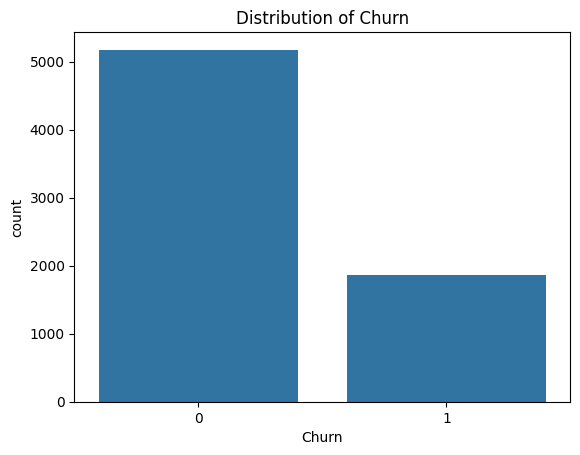


Dropped 'customerID' column.

'TotalCharges' initial type: object
'TotalCharges' type after conversion: float64
NaNs in 'TotalCharges' after coercion: 11
NaNs in 'TotalCharges' after imputation: 0

Number of duplicate rows: 22
Shape after dropping duplicates: (7021, 20)

Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [8]:
#===============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA) & INITIAL PREPROCESSING
#===============================================================================
# Description: Understand the data, identify issues, and perform initial cleaning.
#-------------------------------------------------------------------------------

# --- 3.1. Basic Information ---
print("\n--- Basic Information ---")
df.info()

# --- 3.2. Descriptive Statistics ---
print("\n--- Descriptive Statistics (Numeric) ---")
print(df.describe())
print("\n--- Descriptive Statistics (Object/Categorical) ---")
print(df.describe(include='object'))

# --- 3.3. Target Variable ---
# Convert 'Churn' to numeric (1 for Yes, 0 for No)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("\n--- Churn Value Counts ---")
print(df['Churn'].value_counts(normalize=True))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()
# Observation: The dataset is imbalanced. Churn rate is about 26.5%.

# --- 3.4. Handle 'customerID' ---
# customerID is an identifier and should not be used as a feature.
df = df.drop('customerID', axis=1)
print("\nDropped 'customerID' column.")

# --- 3.5. Handle 'TotalCharges' ---
# 'TotalCharges' is object type, should be numeric. Some values might be spaces.
# Identify non-numeric 'TotalCharges'
print(f"\n'TotalCharges' initial type: {df['TotalCharges'].dtype}")
# Convert to numeric, coercing errors (spaces will become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"'TotalCharges' type after conversion: {df['TotalCharges'].dtype}")

# Check for NaNs introduced
print(f"NaNs in 'TotalCharges' after coercion: {df['TotalCharges'].isnull().sum()}")
# These NaNs typically correspond to customers with tenure = 0.
# We can impute these with 0 or the median. Given tenure=0, 0 is reasonable.
df['TotalCharges'].fillna(0, inplace=True)
print(f"NaNs in 'TotalCharges' after imputation: {df['TotalCharges'].isnull().sum()}")


# --- 3.6. Check for Duplicates ---
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")


# --- 3.7. Identify Feature Types ---
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('Churn') # Remove target from features

categorical_features = df.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# --- 3.8. Basic Visualizations (Optional, for deeper EDA) ---
# Example: Tenure vs Churn
# sns.boxplot(x='Churn', y='tenure', data=df)
# plt.title('Tenure Distribution by Churn')
# plt.show()

# Example: Contract vs Churn
# sns.countplot(x='Contract', hue='Churn', data=df)
# plt.title('Contract Type vs Churn')
# plt.show()

In [9]:
#===============================================================================
# 4. FEATURE ENGINEERING & PREPROCESSING PIPELINE
#===============================================================================
# Description: Create preprocessing pipelines for numerical and categorical features.
# This includes scaling for numerical features and one-hot encoding for categorical ones.
#-------------------------------------------------------------------------------

# --- 4.1. Define Preprocessing Steps ---

# Pipeline for numerical features:
# 1. Impute missing values (if any were left or for future use) with median.
# 2. Scale features using StandardScaler.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # TotalCharges already handled, but good practice
    ('scaler', StandardScaler())
])

# Pipeline for categorical features:
# 1. Impute missing values (if any) with a constant 'missing' value.
# 2. One-hot encode categorical features. 'handle_unknown='ignore'' is useful if test set has new categories.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False for easier handling later
])

# --- 4.2. Create ColumnTransformer ---
# This applies the defined transformations to the respective columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any columns not specified (should be none here if all features are listed)
)

# --- 4.3. Split Data into Training and Testing sets ---
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Important for imbalanced datasets
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nChurn distribution in y_train:\n{y_train.value_counts(normalize=True)}")
print(f"\nChurn distribution in y_test:\n{y_test.value_counts(normalize=True)}")

# --- 4.4. Apply Preprocessing to X_train and X_test ---
# Fit the preprocessor on X_train and transform both X_train and X_test
# This ensures that the test set is transformed using parameters learned from the training set.

# Fit and transform X_train
X_train_processed_np = preprocessor.fit_transform(X_train)

# Transform X_test
X_test_processed_np = preprocessor.transform(X_test)

# Get feature names after one-hot encoding for better interpretability (e.g., for SHAP)
# This step is crucial because ColumnTransformer outputs a NumPy array.
# We need to reconstruct the DataFrame with proper column names.
feature_names_out = preprocessor.get_feature_names_out()

X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_out, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_out, index=X_test.index)

print("\n--- Processed Data Samples ---")
print("X_train_processed head:")
print(X_train_processed.head())
print(f"\nX_train_processed shape: {X_train_processed.shape}")
print("X_test_processed head:")
print(X_test_processed.head())
print(f"\nX_test_processed shape: {X_test_processed.shape}")

X_train shape: (5616, 19)
X_test shape: (1405, 19)
y_train shape: (5616,)
y_test shape: (1405,)

Churn distribution in y_train:
Churn
0   0.736
1   0.264
Name: proportion, dtype: float64

Churn distribution in y_test:
Churn
0   0.735
1   0.265
Name: proportion, dtype: float64

--- Processed Data Samples ---
X_train_processed head:
      num__SeniorCitizen  num__tenure  num__MonthlyCharges  num__TotalCharges  \
2629              -0.440       -1.241                0.193             -0.945   
2650              -0.440       -0.711                0.647             -0.434   
1418              -0.440        1.410                0.820              1.794   
5774              -0.440       -1.119                0.023             -0.857   
2425              -0.440       -0.262               -1.484             -0.782   

      cat__gender_Female  cat__gender_Male  cat__Partner_No  cat__Partner_Yes  \
2629               0.000             1.000            1.000             0.000   
2650              

In [10]:
#===============================================================================
# 5. HANDLING IMBALANCE (SMOTE)
#===============================================================================
# Description: Apply SMOTE (Synthetic Minority Over-sampling Technique) to the
# training data to address class imbalance.
# IMPORTANT: SMOTE should ONLY be applied to the training data, NEVER to the test data.
#-------------------------------------------------------------------------------

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("\n--- Data distribution before SMOTE (Training Set) ---")
print(y_train.value_counts(normalize=True))

print("\n--- Data distribution after SMOTE (Training Set) ---")
print(y_train_smote.value_counts(normalize=True))

print(f"\nShape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_train_smote: {X_train_smote.shape}")

# We will train models on both `X_train_processed, y_train` (original imbalanced)
# and `X_train_smote, y_train_smote` (SMOTE balanced) to compare.


--- Data distribution before SMOTE (Training Set) ---
Churn
0   0.736
1   0.264
Name: proportion, dtype: float64

--- Data distribution after SMOTE (Training Set) ---
Churn
1   0.500
0   0.500
Name: proportion, dtype: float64

Shape of X_train_processed: (5616, 45)
Shape of X_train_smote: (8262, 45)


In [11]:
#===============================================================================
# 6. MODEL TRAINING
#===============================================================================
# Description: Train Random Forest and XGBoost classifiers.
# We'll train two versions of each: one on the original imbalanced training
# data and one on the SMOTE-balanced training data.
#-------------------------------------------------------------------------------

# --- 6.1. Define Models ---
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced') # class_weight for imbalanced
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=sum(y_train==0)/sum(y_train==1)) # scale_pos_weight for imbalanced

rf_model_smote = RandomForestClassifier(random_state=42, n_estimators=100) # No class_weight needed for SMOTE data
xgb_model_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # No scale_pos_weight for SMOTE data

# --- 6.2. Train on Original Imbalanced Data ---
print("\n--- Training on Original Imbalanced Data ---")
rf_model.fit(X_train_processed, y_train)
print("Random Forest trained on original data.")
xgb_model.fit(X_train_processed, y_train)
print("XGBoost trained on original data.")

# --- 6.3. Train on SMOTE-balanced Data ---
print("\n--- Training on SMOTE-balanced Data ---")
rf_model_smote.fit(X_train_smote, y_train_smote)
print("Random Forest trained on SMOTE data.")
xgb_model_smote.fit(X_train_smote, y_train_smote)
print("XGBoost trained on SMOTE data.")


--- Training on Original Imbalanced Data ---
Random Forest trained on original data.
XGBoost trained on original data.

--- Training on SMOTE-balanced Data ---
Random Forest trained on SMOTE data.
XGBoost trained on SMOTE data.



==================== EVALUATION: MODELS ON ORIGINAL DATA ====================

--- Evaluating: Random Forest (Original Data) ---
Accuracy: 0.7715

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.81      0.89      0.85      1033
   Churn (1)       0.59      0.44      0.50       372

    accuracy                           0.77      1405
   macro avg       0.70      0.66      0.68      1405
weighted avg       0.76      0.77      0.76      1405



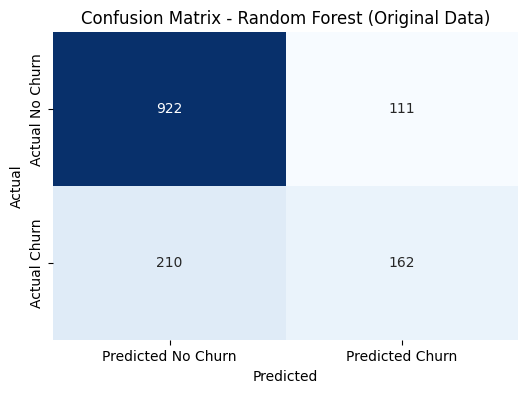

ROC-AUC Score: 0.8102
Precision-Recall AUC Score: 0.5885

--- Evaluating: XGBoost (Original Data) ---
Accuracy: 0.7544

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.86      0.79      0.83      1033
   Churn (1)       0.53      0.65      0.58       372

    accuracy                           0.75      1405
   macro avg       0.70      0.72      0.70      1405
weighted avg       0.77      0.75      0.76      1405



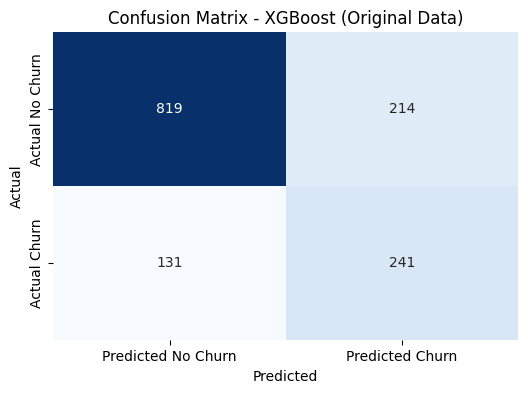

ROC-AUC Score: 0.8163
Precision-Recall AUC Score: 0.6038

==================== EVALUATION: MODELS ON SMOTE DATA ====================

--- Evaluating: Random Forest (SMOTE Data) ---
Accuracy: 0.7779

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.83      0.87      0.85      1033
   Churn (1)       0.59      0.52      0.55       372

    accuracy                           0.78      1405
   macro avg       0.71      0.69      0.70      1405
weighted avg       0.77      0.78      0.77      1405



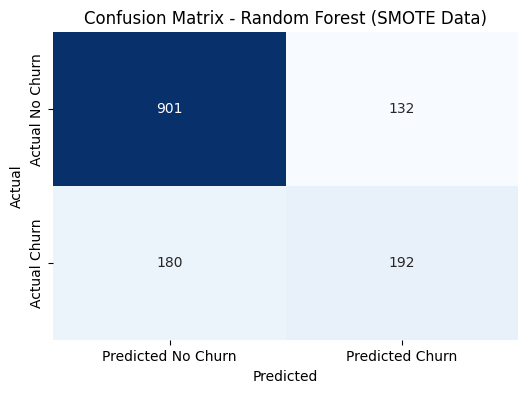

ROC-AUC Score: 0.8076
Precision-Recall AUC Score: 0.5782

--- Evaluating: XGBoost (SMOTE Data) ---
Accuracy: 0.7801

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.84      0.86      0.85      1033
   Churn (1)       0.59      0.55      0.57       372

    accuracy                           0.78      1405
   macro avg       0.72      0.71      0.71      1405
weighted avg       0.78      0.78      0.78      1405



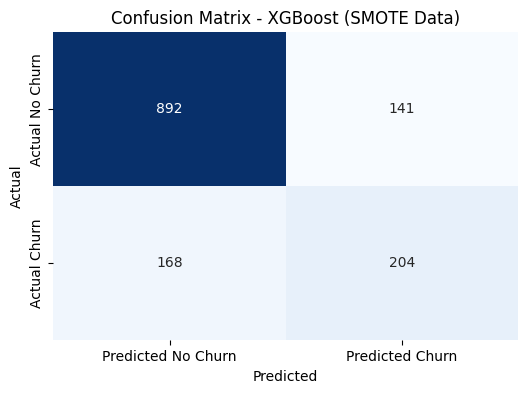

ROC-AUC Score: 0.8217
Precision-Recall AUC Score: 0.6156


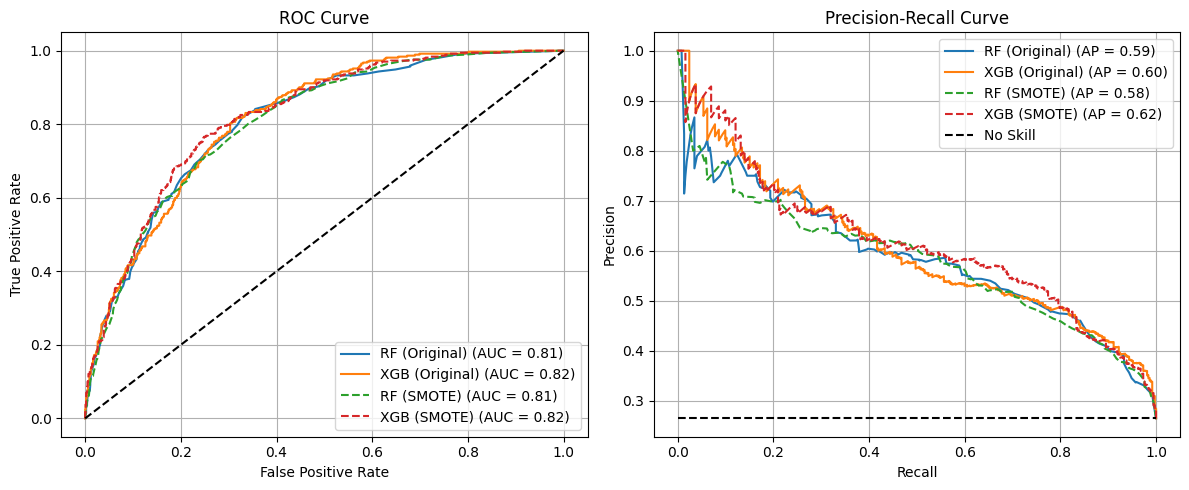

In [12]:
#===============================================================================
# 7. MODEL EVALUATION
#===============================================================================
# Description: Evaluate the trained models using various metrics:
# Accuracy, Classification Report (Precision, Recall, F1-score), Confusion Matrix,
# ROC-AUC Score, ROC Curve, Precision-Recall Curve.
# We will evaluate on the (unseen) X_test_processed and y_test.
#-------------------------------------------------------------------------------

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Helper function to evaluate a model and print/plot metrics."""
    print(f"\n--- Evaluating: {model_name} ---")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Churn', 'Predicted Churn'],
                yticklabels=['Actual No Churn', 'Actual Churn'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Precision-Recall AUC Score
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

    return y_pred, y_pred_proba, roc_auc, pr_auc


# --- 7.1. Evaluate Models Trained on Original Imbalanced Data ---
print("\n" + "="*20 + " EVALUATION: MODELS ON ORIGINAL DATA " + "="*20)
rf_pred, rf_proba, rf_roc_auc, rf_pr_auc = evaluate_model(rf_model, X_test_processed, y_test, "Random Forest (Original Data)")
xgb_pred, xgb_proba, xgb_roc_auc, xgb_pr_auc = evaluate_model(xgb_model, X_test_processed, y_test, "XGBoost (Original Data)")

# --- 7.2. Evaluate Models Trained on SMOTE Data ---
print("\n" + "="*20 + " EVALUATION: MODELS ON SMOTE DATA " + "="*20)
rf_smote_pred, rf_smote_proba, rf_smote_roc_auc, rf_smote_pr_auc = evaluate_model(rf_model_smote, X_test_processed, y_test, "Random Forest (SMOTE Data)")
xgb_smote_pred, xgb_smote_proba, xgb_smote_roc_auc, xgb_smote_pr_auc = evaluate_model(xgb_model_smote, X_test_processed, y_test, "XGBoost (SMOTE Data)")


# --- 7.3. Plot ROC and Precision-Recall Curves ---
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, rf_smote_proba)
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_test, xgb_smote_proba)

plt.plot(fpr_rf, tpr_rf, label=f'RF (Original) (AUC = {rf_roc_auc:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (Original) (AUC = {xgb_roc_auc:.2f})')
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f'RF (SMOTE) (AUC = {rf_smote_roc_auc:.2f})', linestyle='--')
plt.plot(fpr_xgb_smote, tpr_xgb_smote, label=f'XGB (SMOTE) (AUC = {xgb_smote_roc_auc:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--') # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_proba)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, xgb_proba)
prec_rf_smote, rec_rf_smote, _ = precision_recall_curve(y_test, rf_smote_proba)
prec_xgb_smote, rec_xgb_smote, _ = precision_recall_curve(y_test, xgb_smote_proba)

plt.plot(rec_rf, prec_rf, label=f'RF (Original) (AP = {rf_pr_auc:.2f})')
plt.plot(rec_xgb, prec_xgb, label=f'XGB (Original) (AP = {xgb_pr_auc:.2f})')
plt.plot(rec_rf_smote, prec_rf_smote, label=f'RF (SMOTE) (AP = {rf_smote_pr_auc:.2f})', linestyle='--')
plt.plot(rec_xgb_smote, prec_xgb_smote, label=f'XGB (SMOTE) (AP = {xgb_smote_pr_auc:.2f})', linestyle='--')

# Baseline for Precision-Recall (proportion of positive class)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Observation:
# Typically, models trained on SMOTE data show better recall for the minority class (Churn=1),
# which is often desirable in churn prediction (better to identify a potential churner).
# XGBoost often performs well. The choice of model depends on the specific business need
# (e.g., is high recall for churners more important than overall accuracy or precision?).
# For this demo, let's assume XGBoost with SMOTE is our preferred model based on a balance of metrics.


--- SHAP Interpretability for: XGBoost (SMOTE) ---

Generating SHAP Summary Plot (Beeswarm)...


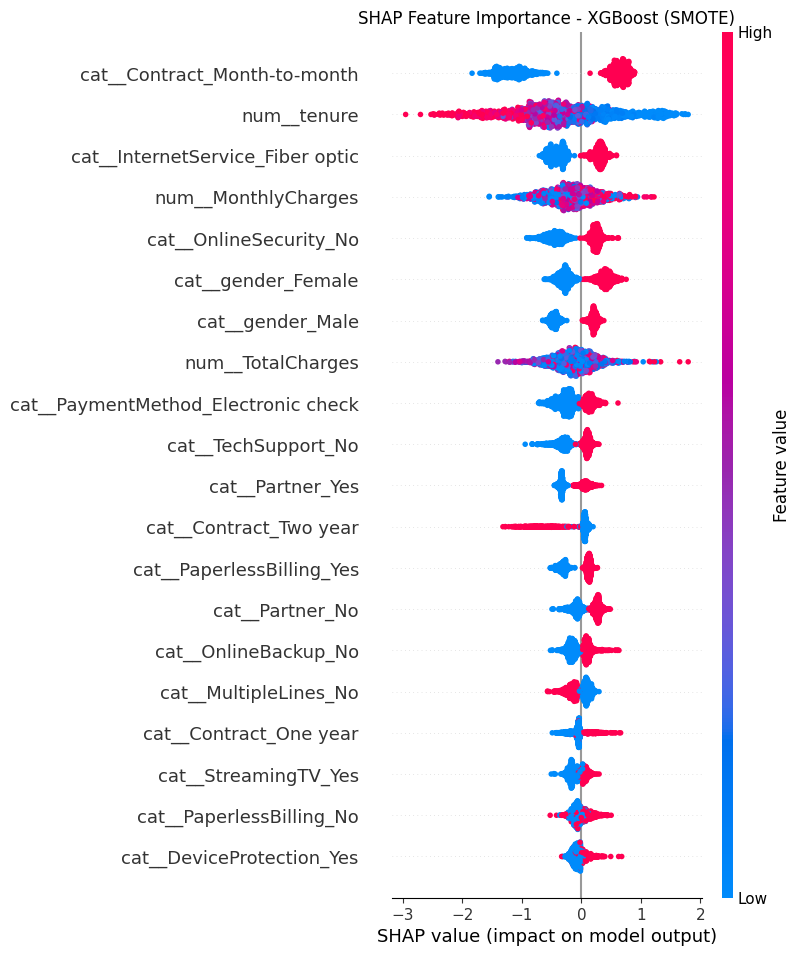


Generating SHAP Bar Plot (Mean Absolute Values)...


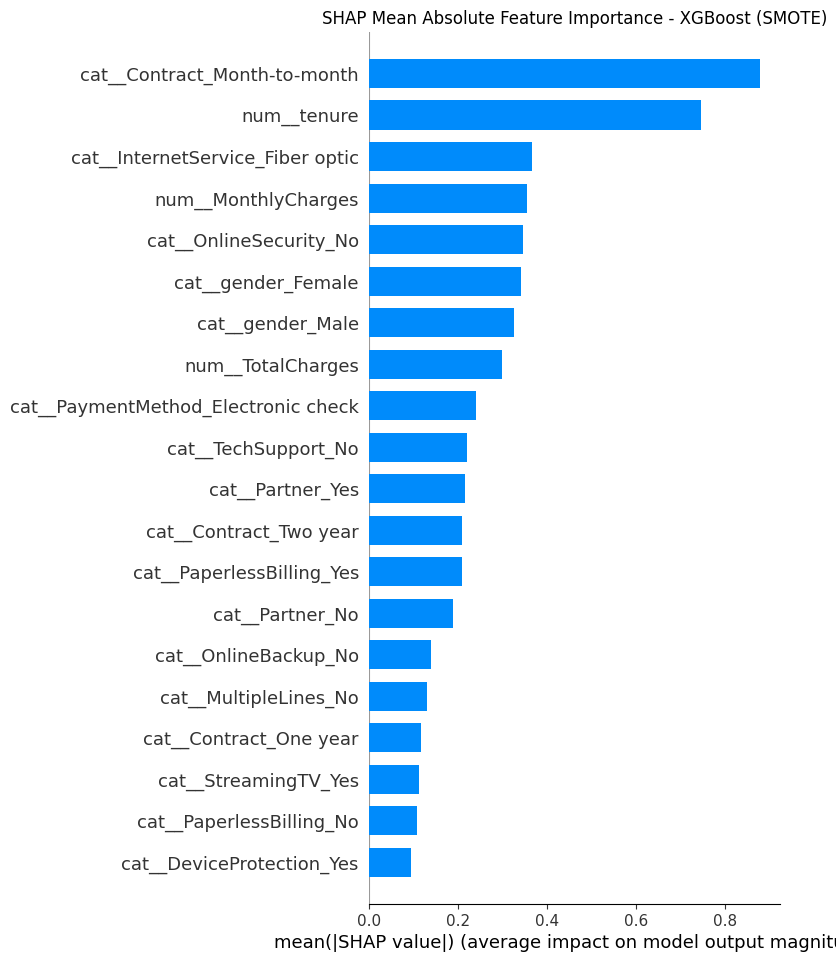


Generating SHAP Dependence Plot for feature: cat__Contract_Month-to-month...


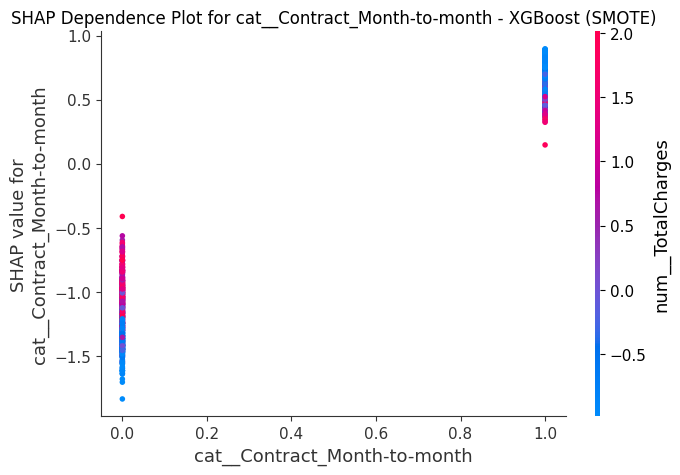


Generating SHAP Force Plot for instance 0...



SHAP analysis complete.


In [13]:
#===============================================================================
# 8. MODEL INTERPRETABILITY (SHAP)
#===============================================================================
# Description: Use SHAP (SHapley Additive exPlanations) to understand model predictions.
# We'll use the XGBoost model trained on SMOTE data as an example.
#-------------------------------------------------------------------------------

# Select the model to interpret (e.g., XGBoost trained on SMOTE data)
chosen_model = xgb_model_smote
chosen_model_name = "XGBoost (SMOTE)"
X_for_shap = X_test_processed # Use the processed test set for explanations

print(f"\n--- SHAP Interpretability for: {chosen_model_name} ---")

# Initialize SHAP explainer
# For tree-based models like XGBoost and RandomForest, TreeExplainer is efficient.
explainer = shap.TreeExplainer(chosen_model)

# Calculate SHAP values for the test set
# This can take a few moments for larger datasets/models
shap_values = explainer.shap_values(X_for_shap)

# --- 8.1. SHAP Summary Plot (Feature Importance) ---
# Shows the global importance of features. Each point is a Shapley value for a feature and an instance.
# The color represents the feature value (red high, blue low).
print("\nGenerating SHAP Summary Plot (Beeswarm)...")
shap.summary_plot(shap_values, X_for_shap, plot_type="dot", show=False) # or plot_type="bar"
plt.title(f"SHAP Feature Importance - {chosen_model_name}")
plt.show()

# --- 8.2. SHAP Bar Plot (Mean Absolute SHAP values) ---
print("\nGenerating SHAP Bar Plot (Mean Absolute Values)...")
shap.summary_plot(shap_values, X_for_shap, plot_type="bar", show=False)
plt.title(f"SHAP Mean Absolute Feature Importance - {chosen_model_name}")
plt.show()


# --- 8.3. SHAP Dependence Plots (Optional) ---
# Shows how a single feature's value affects the prediction,
# potentially colored by an interaction feature.
# Example: Dependence plot for the most important feature
# Get the feature importances based on mean |SHAP value|
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_for_shap.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['feature', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
most_important_feature = importance_df['feature'].iloc[0]

print(f"\nGenerating SHAP Dependence Plot for feature: {most_important_feature}...")
shap.dependence_plot(most_important_feature, shap_values, X_for_shap, interaction_index="auto", show=False)
plt.title(f"SHAP Dependence Plot for {most_important_feature} - {chosen_model_name}")
plt.show()


# --- 8.4. SHAP Force Plot (Explaining a single prediction) ---
# Explain the first prediction in the test set
instance_idx = 0
print(f"\nGenerating SHAP Force Plot for instance {instance_idx}...")

# For a single instance, shap_values[instance_idx] can be used.
# We need shap.Explanation object for nicer plotting if using newer shap versions.
# For older SHAP:
# shap.force_plot(explainer.expected_value, shap_values[instance_idx, :], X_for_shap.iloc[instance_idx, :], matplotlib=True, show=False)
# plt.title(f"SHAP Force Plot for instance {instance_idx} - {chosen_model_name}")
# plt.show()

# For newer SHAP (usually preferred for HTML output in notebooks):
shap.initjs() # Initialize JavaScript visualization
force_plot = shap.force_plot(explainer.expected_value, shap_values[instance_idx,:], X_for_shap.iloc[instance_idx,:])
display(force_plot) # Use display for HTML objects in Colab/Jupyter

# Explain multiple predictions (waterfall plot for each or summary force plot)
# Example of a summary force plot for the first 100 instances:
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_for_shap.iloc[:100,:])
# display(force_plot_multiple)


print("\nSHAP analysis complete.")
# Interpretation:
# - Summary Plot: Features like 'Contract_Month-to-month', 'tenure', 'OnlineSecurity_No'
#   are often important. Red points pushing to the right increase churn probability.
# - Force Plot: Shows how features contribute to pushing a specific prediction
#   away from the base value (average prediction).

In [14]:
#===============================================================================
# 9. SAVE MODEL AND PREPROCESSOR
#===============================================================================
# Description: Save the trained model and the preprocessor for later use,
# for example, in a deployment scenario.
# We'll save the chosen model (XGBoost SMOTE) and the `preprocessor` object.
#-------------------------------------------------------------------------------

# Define file paths for saving
model_path = 'churn_xgb_smote_model.joblib'
preprocessor_path = 'churn_preprocessor.joblib'

# Save the model
joblib.dump(chosen_model, model_path)
print(f"Model saved to {model_path}")

# Save the preprocessor
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to {preprocessor_path}")

# To load them later:
# loaded_model = joblib.load(model_path)
# loaded_preprocessor = joblib.load(preprocessor_path)
# print("\nModel and preprocessor loaded (example).")

Model saved to churn_xgb_smote_model.joblib
Preprocessor saved to churn_preprocessor.joblib


In [15]:
#===============================================================================
# BONUS: DEPLOYMENT AS A REST API (Conceptual Outline using Flask)
#===============================================================================
# Description: This section provides a conceptual outline of how you might
# deploy the trained model as a REST API using Flask.
# This code is NOT meant to be run directly in Colab as a functioning API server.
# It's an illustrative example of the `app.py` file you would create.
#
# To run a Flask app:
# 1. Save the code below as `app.py`.
# 2. Save `churn_xgb_smote_model.joblib` and `churn_preprocessor.joblib` in the same directory.
# 3. Install Flask: `pip install Flask pandas scikit-learn xgboost joblib`
# 4. Run from terminal: `python app.py`
# 5. Send POST requests to `http://127.0.0.1:5000/predict`
#-------------------------------------------------------------------------------

flask_app_code = """
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np # For np.array if needed

# Initialize Flask app
app = Flask(__name__)

# Load the pre-trained model and preprocessor
try:
    model = joblib.load('churn_xgb_smote_model.joblib')
    preprocessor = joblib.load('churn_preprocessor.joblib')
    print("Model and preprocessor loaded successfully for Flask app.")
except Exception as e:
    print(f"Error loading model/preprocessor: {e}")
    model = None
    preprocessor = None

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    if not model or not preprocessor:
        return jsonify({'error': 'Model or preprocessor not loaded'}), 500

    try:
        # Get data from POST request
        json_data = request.get_json(force=True)

        # Convert JSON to DataFrame. Input should match the structure expected by preprocessor.
        # Example: {'tenure': 1, 'MonthlyCharges': 20.0, 'gender': 'Female', ...}
        # Ensure the order of columns is not critical IF using feature names,
        # but it's safer if the input DataFrame for preprocessor.transform has columns
        # in the same order as during `fit`.
        # For robustness, ensure all expected features are present, possibly with defaults.

        # For a single prediction, data might come as a dictionary
        # For multiple predictions, it might be a list of dictionaries
        if isinstance(json_data, dict): # Single prediction
            data_df = pd.DataFrame([json_data])
        elif isinstance(json_data, list): # Batch prediction
            data_df = pd.DataFrame(json_data)
        else:
            return jsonify({'error': 'Invalid input format. Expected JSON object or list of objects.'}), 400

        # Preprocess the input data
        # Ensure 'customerID' and 'Churn' are not in data_df if they were dropped before preprocessor training
        # data_df = data_df.drop(['customerID', 'Churn'], axis=1, errors='ignore')

        # The preprocessor expects specific columns.
        # If your preprocessor was fit on X_train (which had original column names),
        # then data_df should also have these original column names.

        processed_data_np = preprocessor.transform(data_df)

        # The output of preprocessor.transform is a NumPy array.
        # If your model was trained on a DataFrame with feature names (like X_train_processed),
        # it's good practice to convert it back, though many scikit-learn models handle numpy arrays.
        # feature_names_out = preprocessor.get_feature_names_out() # Get from loaded preprocessor
        # processed_data_df = pd.DataFrame(processed_data_np, columns=feature_names_out)

        # Make prediction
        # Use processed_data_np directly if model handles it, or processed_data_df
        prediction_proba = model.predict_proba(processed_data_np)[:, 1] # Probability of churn
        prediction = model.predict(processed_data_np)            # Class label (0 or 1)

        # Prepare response
        # For batch predictions, convert numpy arrays to lists
        if isinstance(json_data, list):
            response = {
                'predictions': prediction.tolist(),
                'probabilities_churn': prediction_proba.tolist()
            }
        else: # Single prediction
            response = {
                'prediction': int(prediction[0]),
                'probability_churn': float(prediction_proba[0])
            }

        return jsonify(response)

    except Exception as e:
        # Log the error e for debugging
        print(f"Prediction error: {e}")
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    # Host 0.0.0.0 makes it accessible on your network, not just localhost
    # Use a proper WSGI server like Gunicorn for production
    app.run(host='0.0.0.0', port=5000, debug=True)
"""

print("\n--- Flask App Code (Conceptual) ---")
print(flask_app_code)
print("\nTo run this Flask app, save it as app.py, ensure model/preprocessor files are present,")
print("install dependencies (Flask, pandas, scikit-learn, xgboost, joblib), and run 'python app.py'.")
print("You can then send POST requests with customer data (JSON) to http://<your-ip>:5000/predict.")
print("Example POST request body for a single prediction (raw JSON in Postman/curl):")
example_request = {
    "gender": "Female", "SeniorCitizen": 0, "Partner": "Yes", "Dependents": "No",
    "tenure": 1, "PhoneService": "No", "MultipleLines": "No phone service",
    "InternetService": "DSL", "OnlineSecurity": "No", "OnlineBackup": "Yes", "DeviceProtection": "No",
    "TechSupport": "No", "StreamingTV": "No", "StreamingMovies": "No", "Contract": "Month-to-month",
    "PaperlessBilling": "Yes", "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85, "TotalCharges": 29.85 # Ensure TotalCharges is float
}
import json
print(json.dumps(example_request, indent=2))

# Note on FastAPI:
# FastAPI is an excellent alternative to Flask, often preferred for its async capabilities,
# automatic data validation (using Pydantic), and interactive API documentation (Swagger UI).
# The structure would be similar: load model, define endpoint, use Pydantic for request body,
# preprocess, predict, return response.


--- Flask App Code (Conceptual) ---

from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np # For np.array if needed

# Initialize Flask app
app = Flask(__name__)

# Load the pre-trained model and preprocessor
try:
    model = joblib.load('churn_xgb_smote_model.joblib')
    preprocessor = joblib.load('churn_preprocessor.joblib')
    print("Model and preprocessor loaded successfully for Flask app.")
except Exception as e:
    print(f"Error loading model/preprocessor: {e}")
    model = None
    preprocessor = None

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    if not model or not preprocessor:
        return jsonify({'error': 'Model or preprocessor not loaded'}), 500

    try:
        # Get data from POST request
        json_data = request.get_json(force=True)
        
        # Convert JSON to DataFrame. Input should match the structure expected by preprocessor.
        # Example: {'tenure': 1, 'Mon